In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge, Circle
import geopandas as gpd
from shapely.geometry import Point
import datetime
import glob

In [2]:
output_folder = '/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/'

## do not run this otherwise ccover your data

In [3]:
base_path = '/N/project/Zli_lab/gongg/stage4_data/stage4_area'
output_folder = '/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/'


file_pattern = '????????.nc'
folder_names = [
   'sub08', 'sub09', 'sub10', 

]

for folder in folder_names:
    print(datetime.datetime.now())
    full_path = os.path.join(base_path, folder, file_pattern)
    all_files = glob.glob(full_path)
    ds = xr.open_mfdataset(all_files)
    lonn = ds.lon.values[:,:,0]
    latt = ds.lat.values[:,:,0]
    prec = ds.tp.values


    n_total = prec.shape[0]  
    perc_all = np.sum(~np.isnan(prec), axis=0) / n_total
    steps_per_year = 2208
    
    n_first12 = 12 * steps_per_year
    perc_first12 = np.sum(~np.isnan(prec[:n_first12]), axis=0) / n_first12

    n_last11 = n_total - n_first12  # 11 * 2208
    perc_last11 = np.sum(~np.isnan(prec[n_first12:]), axis=0) / n_last11

    perc_combined = np.stack([perc_all, perc_first12, perc_last11], axis=0)
    
    ds_perc = xr.Dataset(
        {
            'perc': (['time_period', 'lat', 'lon'], perc_combined)
        },
        coords={
            'time_period': ['all', 'first12', 'last11'],
            'lat': (['lat', 'lon'], latt),
            'lon': (['lat', 'lon'], lonn)
        }
    )
    
    
    ds_perc.to_netcdf(output_folder+'missing_perc_'+folder+'.nc')

2025-03-23 16:38:27.316496


KeyboardInterrupt: 

In [11]:
import xarray as xr

for i in range(1, 31):
    filename = f"/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub{i:02d}.nc"
    ds = xr.open_dataset(filename)
    print(f"{filename}: {ds.perc.values.shape}")


/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub01.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub02.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub03.nc: (3, 88, 375)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub04.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub05.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub06.nc: (3, 88, 375)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub07.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub08.nc: (3, 88, 373)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub09.nc: (3, 88, 375)
/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub10.nc: (3, 88, 373)
/N/project

In [15]:
import glob
import numpy as np
import xarray as xr

# 1. 获取所有文件并按文件名排序，确保顺序正确（注意文件路径）
files = sorted(glob.glob("/N/project/Zli_lab/gongg/stage4_data/stage4_missing_percentage/missing_perc_sub*.nc"))
assert len(files) == 30, f"Expected 30 files, but got {len(files)}"

# 2. 将文件列表按10行3列排列（第一3个为第一行，接下来的3个为第二行，以此类推）
files_grid = np.array(files).reshape(10, 3)

# 3. 初始化最终数组，形状为 (3, 881, 1121)，全部填充 NaN
final_arr = np.full((3, 881, 1121), np.nan)

# 4. 利用累计偏移量将各个 tile 放到正确的位置
lat_offset = 0  # 用于累计垂直方向的偏移
for i in range(10):  # 遍历 10 行
    # 打开当前行的第一块数据，确定该行所有 tile 的纬向尺寸（tile height）
    ds_tile0 = xr.open_dataset(files_grid[i, 0])
    tile_height = ds_tile0.perc.values.shape[1]
    
    lon_offset = 0  # 每一行内部，水平方向的起始偏移
    for j in range(3):  # 遍历 3 列
        ds_tile = xr.open_dataset(files_grid[i, j])
        tile = ds_tile.perc.values  # 形状 (3, tile_height, tile_width)
        tile_width = tile.shape[2]
        # 将当前 tile 放入最终数组中对应的位置
        final_arr[:, lat_offset:lat_offset + tile_height, lon_offset:lon_offset + tile_width] = tile
        lon_offset += tile_width  # 更新当前行的水平方向偏移
    lat_offset += tile_height  # 更新垂直方向偏移

print("最终数组形状:", final_arr.shape)


最终数组形状: (3, 881, 1121)


In [4]:
ds_ref = xr.open_dataset('/N/project/Zli_lab/gongg/stage4_data/stage4_daily/20210617.nc')

In [5]:
ds_ref

<xarray.Dataset> Size: 205MB
Dimensions:  (time: 24, y: 881, x: 1121)
Coordinates:
    lat      (y, x) float64 8MB ...
    lon      (y, x) float64 8MB ...
  * time     (time) datetime64[ns] 192B 2021-06-17 ... 2021-06-17T23:00:00
Dimensions without coordinates: y, x
Data variables:
    tp       (time, y, x) float64 190MB ...

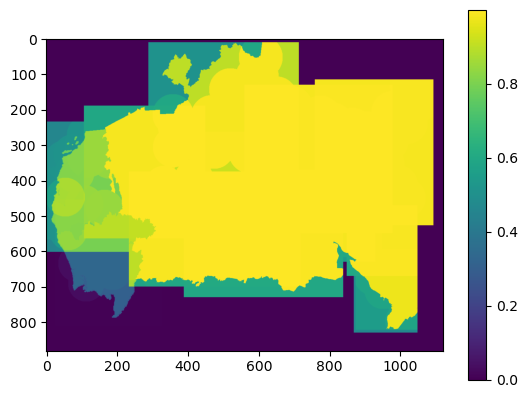

In [18]:
plt.imshow(final_arr[0])
plt.colorbar()